In [1]:
include("../src/JuliaMBD.jl")

Main.JuliaMBD

In [2]:
using DifferentialEquations
using Plots
using .JuliaMBD

In [3]:
## MSD

@model MSD begin
    @parameter begin
        M
        D
        k
        g = 9.8
    end
    @block begin
        in1 = Inport(:in1)
        out1 = Outport(:out1)
        constant1 = Constant(value = M*g)
        gain1 = Gain(K = D)
        gain2 = Gain(K = k)
        gain3 = Gain(K = 1/M)
        int1 = Integrator()
        int2 = Integrator()
        constant2 = Constant(value = M*g/k)
        sum1 = Add(signs=[:+, :+, :-, :-])
    end
    @connect begin
        in1.out => sum1.in1
        constant1.out => sum1.in2
        gain1.out => sum1.in3
        gain2.out => sum1.in4
        sum1.out => gain3.in
        gain3.out => int1.in
        int1.out => int2.in
        constant2.out => int2.initialcondition
        int1.out => gain1.in
        int2.out => gain2.in
        int2.out => out1.in
    end
end

MSD (generic function with 1 method)

In [4]:
## test

@model Test begin
    @parameter begin
        M
        D
        k
        f
        p_cycle
        p_width
    end
    @block begin
        msd = MSD(M=M, D=D, k=k)
        pulse = JuliaMBD.PulseGenerator(amplitude=f, period=p_cycle, pulsewidth=p_width, phasedelay=10.0)
    end
    @connect begin
        pulse.out => msd.in1
    end
    @scope begin
        pulse.out => F
        msd.out1 => x
    end
end

Test (generic function with 1 method)

  4.752025 seconds (19.23 M allocations: 1.039 GiB, 2.92% gc time, 99.00% compilation time: 9% of which was recompilation)


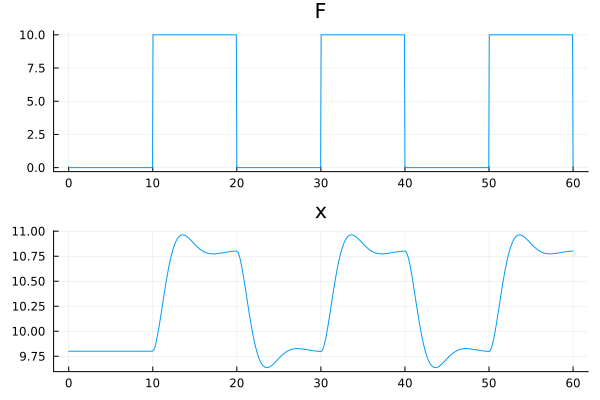

In [5]:
@time begin
    m = @compile Test(M=10, D=10, k=10, f=10, p_cycle=20, p_width=50)
    result = simulate(m, tspan=(0.0, 60.0))
    plot(result)
end

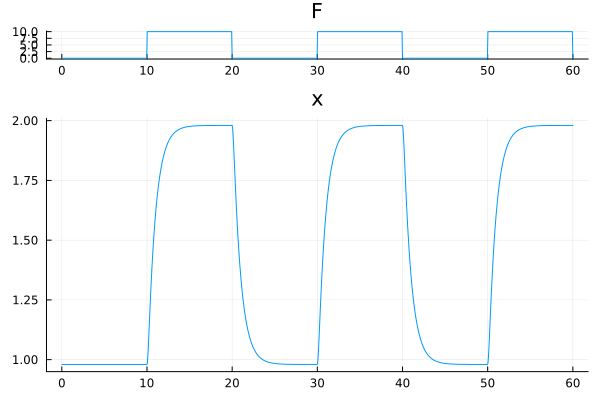

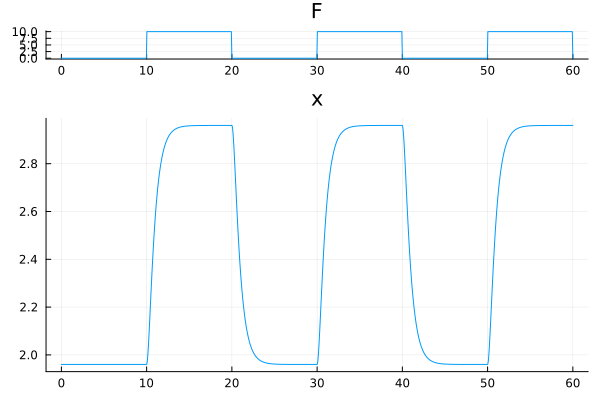

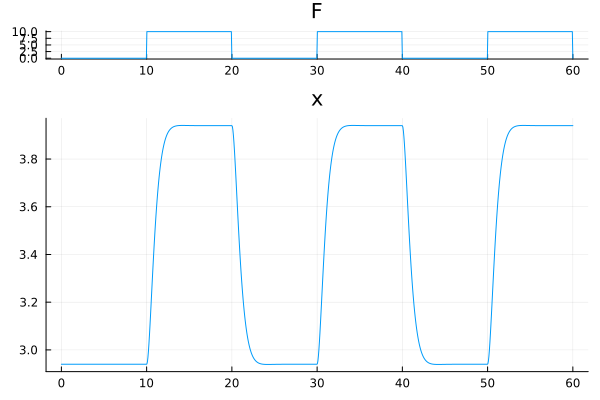

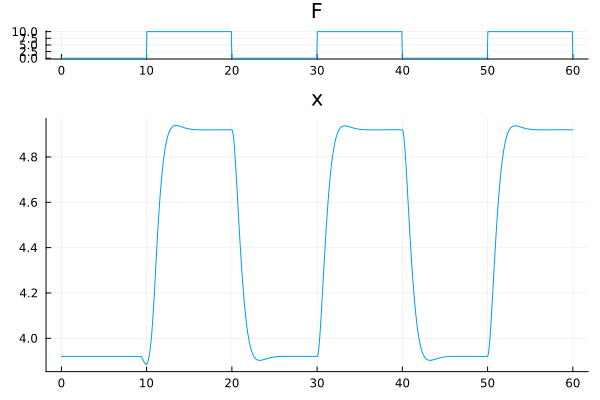

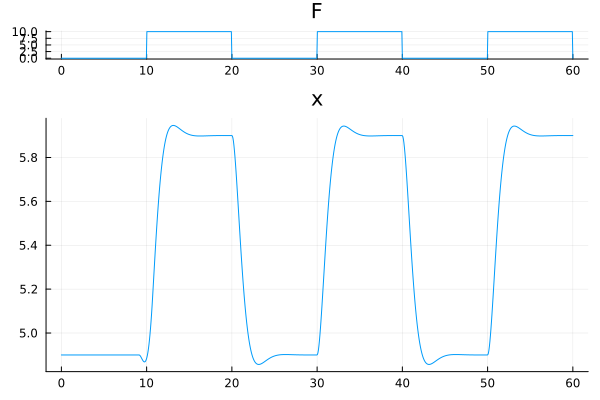

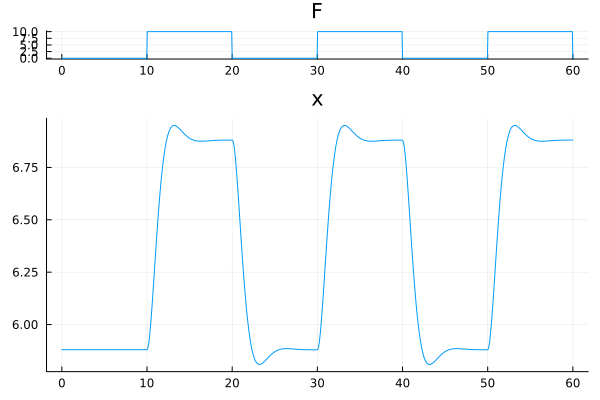

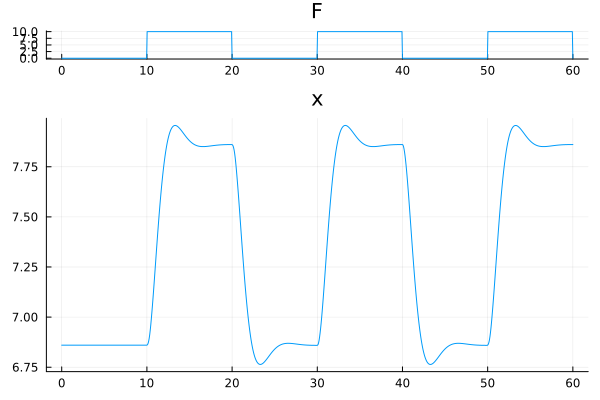

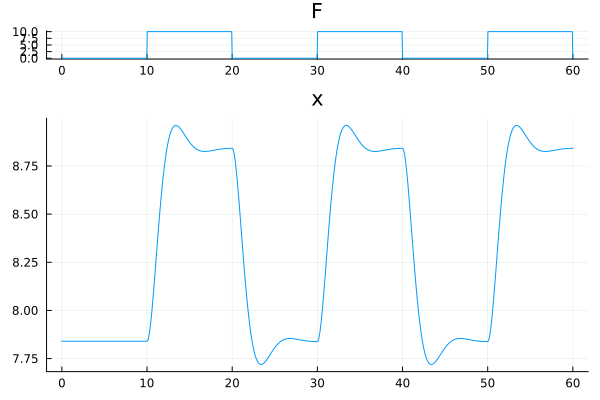

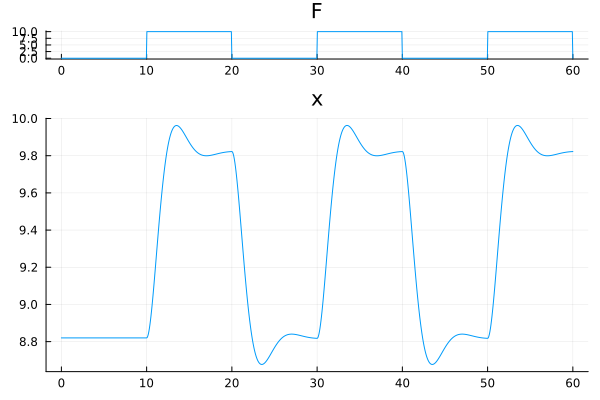

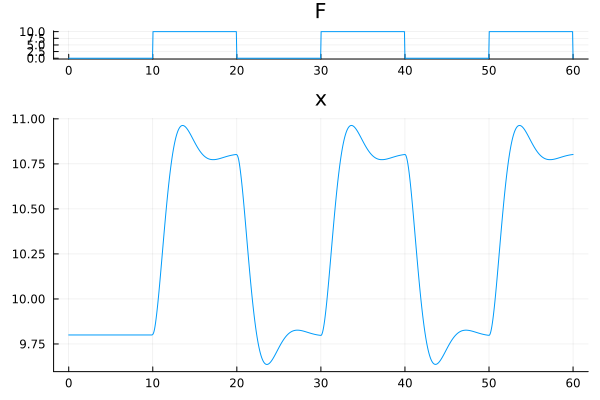

  0.406756 seconds (1.16 M allocations: 77.101 MiB, 40.07% compilation time)


In [9]:
@time begin
    m = @compile Test(M=@v(M), D=10, k=10, f=10, p_cycle=20, p_width=50)
    for M = 1:10
        result = simulate(m, tspan=(0.0, 60.0), parameters=(M=M,))
        display(plot(result, layout=grid(2, 1, heights=[0.1, 0.9])))
    end
end